In [1]:
import sys
import os

from transformers.trainer_pt_utils import log_metrics

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, train_val_split, get_dimensions, \
    scale, \
    metrics_r, get_device, plot_history

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train, tune

## Set Working Device

In [5]:
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


## Read Features and Targets

In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [7]:
targets = ["StartYear", "YearRange"]

In [8]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


## Train-Validation Split

In [9]:
X, y = train_val_split(X, y)

## Scale Regression Targets

In [10]:
y, y_scaler = scale(y)

In [11]:
y = {subset: torch.tensor(_y, dtype=torch.float32, device=device) for subset, _y in y.items()}

## Dimensions

In [12]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


## Torch Datasets and Dataloaders

In [13]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Tune Model



In [14]:
criterion = nn.MSELoss()
metrics = metrics_r

param_grid = {
    # Architecture Params
    # "hidden_size": [128, 256, 512, 1024],
    "hidden_size": [256, 512],
    "activation": ["relu", "gelu"],
    # "dropout": [0, 0.1, 0.3, 0.5],
    "dropout": [0.1, 0.3],
    # "blocks": [1, 2, 3, 5, 10],
    "blocks": [3, 5, 10],
    "hidden_size_pattern": ["decreasing", "constant"],

    # Training Params
    # "lr": [1e-2, 1e-3, 1e-4, 1e-5],
    "lr": [1e-3, 1e-4],
    # "weight_decay": [1e-5, 1e-6, 1e-7],
    "weight_decay": [1e-5, 1e-6],
}

In [15]:
hp_results = {}
hp_histories = []

In [16]:
feature_type = "tfidf"
hp_result, hp_history = tune(
    param_grid,
    [X_dim[feature_type]],
    y_dim,
    loaders["train"][feature_type],
    loaders["val"][feature_type],
    criterion,
    metrics,
    device,
    y_scaler,
    log_metrics=["mae"],
    chronology_target="years"
)

hp_results[feature_type] = hp_result

hp_history.insert(0, 'model_feature_type', feature_type)
hp_histories += [hp_history]

+-----------+-------------+------------+---------+--------+---------------------+--------+--------------+-----------+-----------+-----------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |     lr | weight_decay |  val_loss |     mae_0 |     mae_1 |
+-----------+-------------+------------+---------+--------+---------------------+--------+--------------+-----------+-----------+-----------+
|   001/192 |         256 |       relu |     0.1 |      3 |          decreasing |  0.001 |        1e-05 |    0.7103 |   38.3288 |   10.4105 | *
|   002/192 |         256 |       relu |     0.1 |      3 |          decreasing |  0.001 |        1e-06 |    0.7072 |   38.9474 |   10.2325 | *
|   003/192 |         256 |       relu |     0.1 |      3 |          decreasing | 0.0001 |        1e-05 |    0.6884 |   39.1512 |   10.2548 | *
|   004/192 |         256 |       relu |     0.1 |      3 |          decreasing | 0.0001 |        1e-06 |    0.6936 |   38.4730 |   10.4779 |


In [17]:
hp_history.sort_values("val_loss").head(100)

,model_feature_type,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
6,tfidf,relu,3,0.1,256,constant,0.0001,0.000010,0.535051,0.673395,37.897888,10.394637,49.049648,12.530911,0.518437,0.220022,30.885895,9.884153
16,tfidf,relu,3,0.3,256,decreasing,0.0010,0.000010,0.424977,0.674614,36.333660,10.254250,48.812275,12.687943,0.523087,0.200351,24.201096,9.750834
37,tfidf,relu,5,0.1,256,constant,0.0010,0.000001,0.505277,0.675162,37.500370,9.999688,50.133366,12.458893,0.496923,0.228962,28.922470,9.386595
61,tfidf,relu,5,0.3,512,constant,0.0010,0.000001,0.335512,0.677176,36.731995,10.060456,48.677925,12.648464,0.525709,0.205320,25.046646,8.332052
40,tfidf,relu,5,0.1,512,decreasing,0.0010,0.000010,0.567338,0.679778,37.561390,10.449737,49.335926,12.637841,0.512800,0.206654,28.611115,10.322656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,tfidf,gelu,3,0.3,512,constant,0.0010,0.000001,0.626218,0.733438,41.825733,10.524571,53.251682,12.854306,0.432393,0.179244,32.018127,9.968676
96,tfidf,gelu,3,0.1,256,decreasing,0.0010,0.000010,0.614690,0.733868,41.485657,10.450378,53.114754,12.816572,0.435308,0.184056,33.548065,9.704582
32,tfidf,relu,5,0.1,256,decreasing,0.0010,0.000010,0.422361,0.734322,38.410557,10.636481,51.496433,13.033273,0.469195,0.156231,25.527435,8.617987
97,tfidf,gelu,3,0.1,256,decreasing,0.0010,0.000001,0.608333,0.734491,41.010803,10.435335,53.303040,12.745529,0.431298,0.193076,31.684479,10.116903


In [18]:
hp_history.sort_values("mae_0").head()

,model_feature_type,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
77,tfidf,relu,10,0.1,512,constant,0.001,0.000001,0.587959,0.783241,35.633152,12.075846,50.022308,14.177215,0.499149,0.001614,23.177200,9.438070
16,tfidf,relu,3,0.3,256,decreasing,0.001,0.000010,0.424977,0.674614,36.333660,10.254250,48.812275,12.687943,0.523087,0.200351,24.201096,9.750834
56,tfidf,relu,5,0.3,512,decreasing,0.001,0.000010,0.375253,0.698727,36.401775,10.421831,48.875076,12.948037,0.521859,0.167231,24.263092,9.298313
57,tfidf,relu,5,0.3,512,decreasing,0.001,0.000001,0.318203,0.689376,36.419910,10.274539,49.200333,12.813963,0.515474,0.184388,22.742340,8.465163
45,tfidf,relu,5,0.1,512,constant,0.001,0.000001,0.245153,0.696772,36.478146,10.518407,48.299614,13.046271,0.533052,0.154547,26.462692,8.540536


In [19]:
hp_result

{'val_loss': 0.6733946800231934,
 'train_loss': 0.5350507497787476,
 'params': {'activation': 'relu',
  'blocks': 3,
  'dropout': 0.1,
  'hidden_size': 256,
  'hidden_size_pattern': 'constant',
  'lr': 0.0001,
  'weight_decay': 1e-05},
 'scores': {'mae': [37.89788818359375, 10.394637107849121],
  'rmse': [49.04964828491211, 12.530911445617676],
  'r2': [0.5184372663497925, 0.22002238035202026],
  'medae': [30.885894775390625, 9.884153366088867]},
 'time': 162.21082305908203}

In [20]:
import json

with open("best_params.json", "w") as f:
    json.dump(hp_result, f, indent=2)

In [21]:
import pandas as pd

hp_history_full = pd.concat(hp_histories, axis=0, ignore_index=True)
hp_history_full.to_csv("hp_history.csv", index=False)

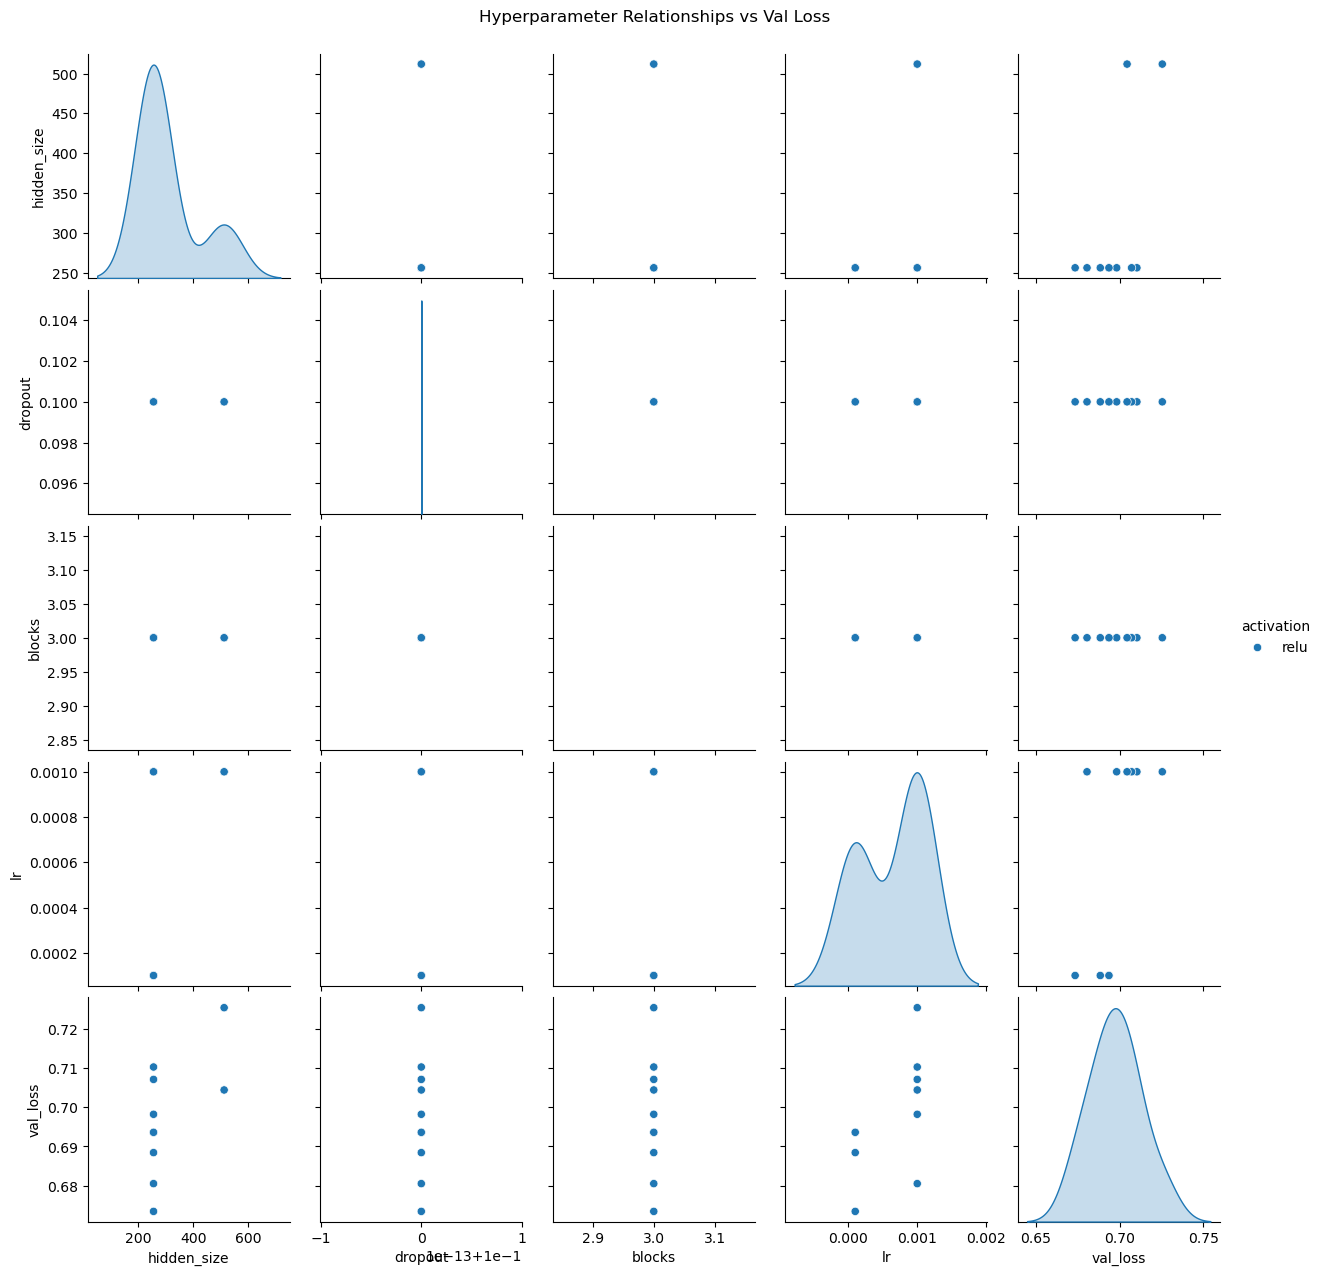

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    hp_histories[0].head(10),
    vars=["hidden_size", "dropout", "blocks", "lr", "val_loss"],
    hue="activation",
    diag_kind="kde",
)
plt.suptitle("Hyperparameter Relationships vs Val Loss", y=1.02)
plt.show()


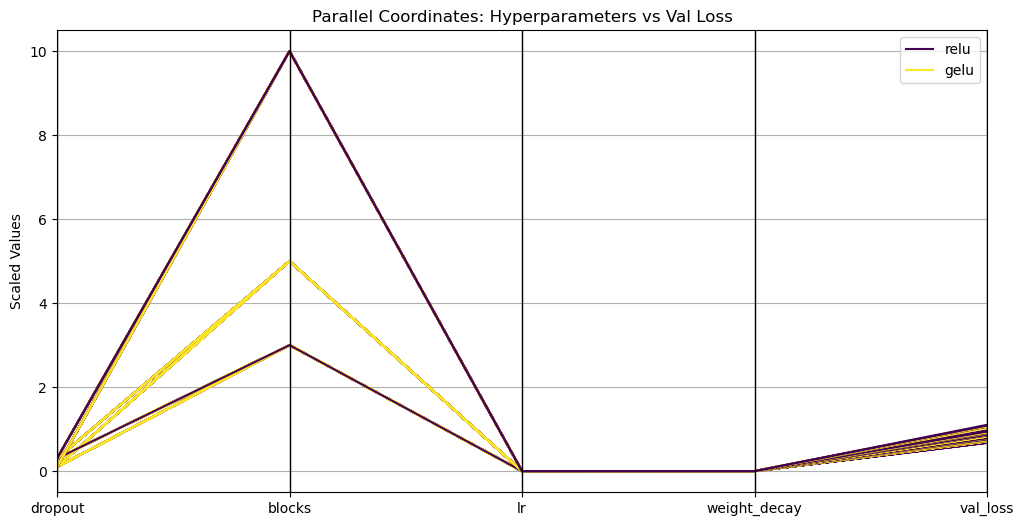

In [26]:
from pandas.plotting import parallel_coordinates

cols = ["activation", "dropout", "blocks", "lr", "weight_decay", "val_loss"]
plt.figure(figsize=(12,6))
parallel_coordinates(hp_histories[0][cols].sort_values("val_loss"), class_column="activation", colormap="viridis")
plt.title("Parallel Coordinates: Hyperparameters vs Val Loss")
plt.ylabel("Scaled Values")
plt.show()


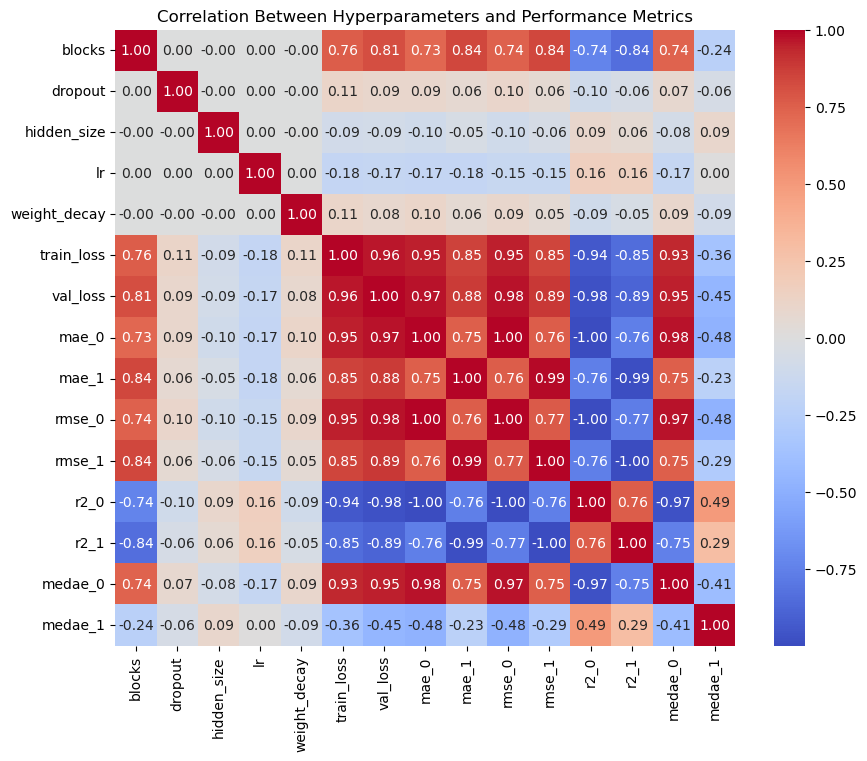

In [27]:
numeric_cols = hp_histories[0].select_dtypes(include=["number"])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Hyperparameters and Performance Metrics")
plt.show()


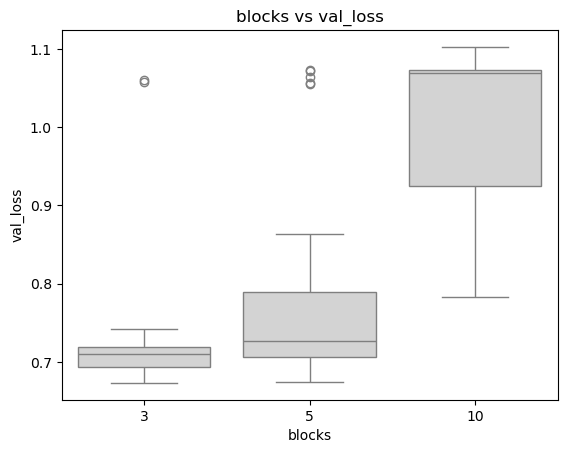

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=hp_histories[0], x='blocks', y='val_loss', alpha=0.7)
sns.boxplot(data=hp_histories[0], x='blocks', y='val_loss', color='lightgray')
plt.title("blocks vs val_loss")
plt.show()


In [40]:
from utils import metrics_c
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tuning_results(results, param_grid, topN=10, global_norm=True):
    """
    Display top-N parameter combinations from hyperparameter tuning with color gradients.
    """
    # Convert to DataFrame if needed
    df = pd.DataFrame(results).copy()

    # Sort by val loss
    sort_col = "val_loss" if "val_loss" in df.columns else df.columns[df.columns.str.contains("val", case=False)][0]
    df = df.sort_values(sort_col, ascending=True).reset_index(drop=True)
    df_top = df.head(topN).reset_index(drop=True)

    # Identify groups
    param_cols = list(param_grid.keys())
    loss_cols = [c for c in df.columns if "loss" in c.lower()]
    metric_cols = [c for c in df.columns if any(m in c.lower() for m in metrics_r | metrics_c)]

    # Detect numeric vs categorical safely
    num_cols, cat_cols = [], []
    for col in param_cols:
        # If column is numeric dtype OR all values can be cast to float safely
        try:
            _ = df[col].astype(float)
            num_cols.append(col)
        except (ValueError, TypeError):
            cat_cols.append(col)

    # Color maps
    color_maps = {
        "params": "YlGnBu",
        "categorical": sns.color_palette("Set3", as_cmap=True),
        "loss": "RdYlBu_r",
        "metrics": "Greens"
    }

    # Pick normalization base
    norm_df = df if global_norm else df_top

    # Styler setup
    styler = df_top.style.format(precision=4)

    # Sequential colormap for numeric params
    for col in num_cols:
        styler = styler.background_gradient(
            cmap=color_maps["params"],
            subset=[col],
            vmin=norm_df[col].min(),
            vmax=norm_df[col].max()
        )

    # Qualitative colors for categorical params
    if cat_cols:
        # Generate distinct colors for each category value
        palette = sns.color_palette("Set3", n_colors=max(3, len(cat_cols) * 3))
        cat_colors = {val: palette[i % len(palette)] for i, val in enumerate(pd.unique(df[cat_cols].values.ravel()))}

        def color_cat(val):
            return f"background-color: rgb({int(cat_colors[val][0]*255)}, {int(cat_colors[val][1]*255)}, {int(cat_colors[val][2]*255)})"

        for col in cat_cols:
            styler = styler.map(color_cat, subset=[col])

    # Diverging colormap for losses (lower = better)
    for col in loss_cols:
        styler = styler.background_gradient(
            cmap=color_maps["loss"],
            subset=[col],
            vmin=norm_df[col].min(),
            vmax=norm_df[col].max()
        )

    # Sequential colormap for metrics (higher = better)
    for col in metric_cols:
        styler = styler.background_gradient(
            cmap=color_maps["metrics"],
            subset=[col],
            vmin=norm_df[col].min(),
            vmax=norm_df[col].max()
        )

    # Highlight best row
    styler = styler.highlight_min(subset=[sort_col], color="lightgreen")

    # Style adjustments
    styler.set_properties(**{
        'text-align': 'center',
        'font-size': '14px'
    })

    styler.set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14px'), ('text-align', 'center')]}
    ])

    display(styler)


In [42]:
plot_tuning_results(hp_histories[0], param_grid, global_norm=False)

,model_feature_type,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
0,tfidf,relu,3,0.1000,256,constant,0.0001,0.0000,0.5351,0.6734,37.8979,10.3946,49.0496,12.5309,0.5184,0.2200,30.8859,9.8842
1,tfidf,relu,3,0.3000,256,decreasing,0.0010,0.0000,0.4250,0.6746,36.3337,10.2542,48.8123,12.6879,0.5231,0.2004,24.2011,9.7508
2,tfidf,relu,5,0.1000,256,constant,0.0010,0.0000,0.5053,0.6752,37.5004,9.9997,50.1334,12.4589,0.4969,0.2290,28.9225,9.3866
3,tfidf,relu,5,0.3000,512,constant,0.0010,0.0000,0.3355,0.6772,36.7320,10.0605,48.6779,12.6485,0.5257,0.2053,25.0466,8.3321
4,tfidf,relu,5,0.1000,512,decreasing,0.0010,0.0000,0.5673,0.6798,37.5614,10.4497,49.3359,12.6378,0.5128,0.2067,28.6111,10.3227
5,tfidf,relu,5,0.3000,512,constant,0.0010,0.0000,0.4635,0.6800,37.5470,10.2964,49.8535,12.5984,0.5025,0.2116,25.8309,10.2403
6,tfidf,relu,3,0.1000,256,constant,0.0010,0.0000,0.4247,0.6805,37.3014,10.1844,49.7077,12.5897,0.5054,0.2127,28.5868,8.9685
7,tfidf,relu,5,0.1000,256,constant,0.0010,0.0000,0.3649,0.6831,38.6182,10.2007,51.3804,12.4283,0.4716,0.2327,28.9188,10.5069
8,tfidf,relu,5,0.1000,512,constant,0.0001,0.0000,0.4416,0.6836,38.4655,10.5131,49.6406,12.6082,0.5068,0.2104,29.7659,9.2003
9,tfidf,relu,3,0.3000,256,decreasing,0.0010,0.0000,0.4934,0.6853,36.5404,10.3282,49.1616,12.7274,0.5162,0.1954,25.0332,9.4593
